In [253]:
# ECGR 4105-080 Assignment 4
# Anthony Almonte
# #800916043
# 7/22/25

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd     # import libraries

from sklearn.model_selection import train_test_split # training/validation data split
from sklearn.preprocessing import StandardScaler     # Standardization
from sklearn.preprocessing import MinMaxScaler       # Normalization

from sklearn.metrics import confusion_matrix         # confusion matrix
from sklearn import metrics                          # accuracy, precision, recall

from sklearn.decomposition import PCA                # PCA
from sklearn.svm import SVC                          # SVC
from sklearn.svm import SVR                          # SVR

In [254]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/ECGR 4105 csv/cancer.csv' # Google Drive file path
file_path_2 = '/content/drive/My Drive/ECGR 4105 csv/Housing.csv'
df = pd.DataFrame(pd.read_csv(file_path))
df_2 = pd.DataFrame(pd.read_csv(file_path_2))
df.head() # obtains first 'n' rows from dataset, n=5
M=len(df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [255]:
#df.describe()
#df_2.describe()

# **Feature Selection and Encoding**

In [256]:
binary_col = ['diagnosis'] # yes/no columns

# binary conversion: 1 - malignant 0 - benign
for col in binary_col:
    df[col] = df[col].map({'M': 1, 'B': 0})

X_0 = df.iloc[:, 2:32].values # selecting feature columns
Y_0 = df.iloc[:, 1] # target variable

#display(df.head()) # confirm conversion

In [257]:
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea'] # yes/no columns

# binary conversion: yes to 1 and no to 0
for col in binary_cols:
    df_2[col] = df_2[col].map({'yes': 1, 'no': 0})

X_2 = df_2.iloc[:, 1:11].values
Y_2 = df_2.iloc[:, 0]

#display(df_2.head())

# **Data Split**

In [258]:
X_train, X_val, Y_train, Y_val = train_test_split(X_0, Y_0, test_size = 0.2, train_size = 0.8, random_state = 1) # 80/20% Data Split
X_train_2, X_val_2, Y_train_2, Y_val_2 = train_test_split(X_2, Y_2, test_size = 0.2, train_size = 0.8, random_state = 1)

# **Scaling**

In [259]:
X_std = StandardScaler()                 # feature scaling
X_train = X_std.fit_transform(X_train)   # fit - calculate mean and std deviation for each feature
X_val = X_std.transform(X_val)           # transform - standardize data using parameters from 'fit'

X_std_2 = StandardScaler()
X_train_2 = X_std_2.fit_transform(X_train_2)
X_val_2 = X_std_2.transform(X_val_2)

# **PCA: Dimensionality Reduction (SVC)**

In [260]:
# dimensionality reduction for 2D plotting
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

print(f"Original # of features: {X_train.shape[1]}")
print(f"After PCA: {X_train_pca.shape[1]}")

Original # of features: 30
After PCA: 2


In [261]:
svc_model_pca = SVC(kernel ='linear', C=1.0)
svc_model_pca.fit(X_train_pca, Y_train);

In [262]:
# Function provided by Vinit Katariya
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision functions for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none', edgecolors='k')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

# **Figure 1-1**

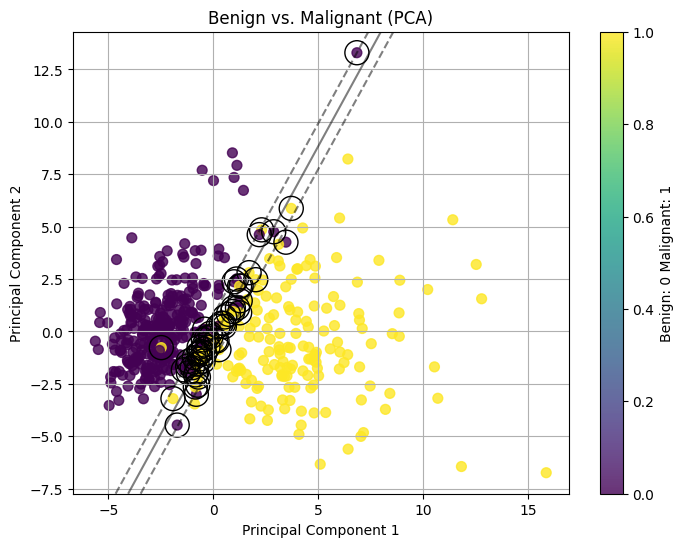

In [263]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=Y_train, cmap='viridis', s=50, alpha=0.8)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Benign vs. Malignant (PCA)')
plt.colorbar(label='Benign: 0 Malignant: 1')
plt.grid(True)

plot_svc_decision_function(svc_model_pca)

plt.show() # plot with two components for visualization

# **'N' Independent Training (SVC)**

In [264]:
pca_results = [] # empty lists for results and confusion matrix
cf_mts = []

# for loop to perform 'n' number of independent training
# pca + SVC
for n in range(1,30):
  pca = PCA(n_components=n)
  X_train_pca = pca.fit_transform(X_train)
  X_val_pca = pca.transform(X_val)

  #svc_model_pca = SVC(C = 1.0, kernel = 'linear', gamma = 'scale')                               # C = 1.0 by default
  #svc_model_pca = SVC(C = 1.0, kernel = 'rbf', gamma = 'scale')                                  # kernel = 'rbf' by default
  #svc_model_pca = SVC(C = 1.0, kernel = 'poly', gamma = 'scale', coef0 = 0.5, degree = 1)        # degree = 3 by default, ignored by other kernels
  svc_model_pca = SVC(C = 1.0, kernel = 'sigmoid', gamma = 'scale', coef0 = 0)                   # gamma = 'scale' by default
  svc_model_pca.fit(X_train_pca, Y_train)                                                         # coef0 = 0 by default, not significant in rbf
  predict_pca = svc_model_pca.predict(X_val_pca)

  pca_accuracy = metrics.accuracy_score(Y_val, predict_pca)
  pca_precision = metrics.precision_score(Y_val, predict_pca)
  pca_recall = metrics.recall_score(Y_val, predict_pca)
  pca_f1 = metrics.f1_score(Y_val, predict_pca)
  pca_cf_mtx = confusion_matrix(Y_val, predict_pca)
# .append to create a results list
  pca_results.append({
      "PCA Components": n,
      "Accuracy": pca_accuracy,
      "Precision": pca_precision,
      "Recall": pca_recall,
      "F1 Score": pca_f1
  })

  # .append the confusion matrix to the list
  cf_mts.append(pca_cf_mtx)

# using list to create DataFrame
pca_results_df = pd.DataFrame(pca_results)
display(pca_results_df)

# loop through the cf_mts list to print all confusion matrices
for i, cf_mts_pca in enumerate(cf_mts):
  print(f"\nConfusion Matrix for PCA Component #{i+1}:\n{cf_mts_pca}")

,PCA Components,Accuracy,Precision,Recall,F1 Score
0,1,0.894737,0.840909,0.880952,0.860465
1,2,0.903509,0.878049,0.857143,0.867470
2,3,0.912281,0.944444,0.809524,0.871795
3,4,0.921053,0.971429,0.809524,0.883117
4,5,0.956140,0.974359,0.904762,0.938272
5,6,0.947368,0.973684,0.880952,0.925000
6,7,0.956140,0.974359,0.904762,0.938272
7,8,0.947368,0.973684,0.880952,0.925000
8,9,0.947368,0.973684,0.880952,0.925000
9,10,0.929825,1.000000,0.809524,0.894737



Confusion Matrix for PCA Component #1:
[[65  7]
 [ 5 37]]

Confusion Matrix for PCA Component #2:
[[67  5]
 [ 6 36]]

Confusion Matrix for PCA Component #3:
[[70  2]
 [ 8 34]]

Confusion Matrix for PCA Component #4:
[[71  1]
 [ 8 34]]

Confusion Matrix for PCA Component #5:
[[71  1]
 [ 4 38]]

Confusion Matrix for PCA Component #6:
[[71  1]
 [ 5 37]]

Confusion Matrix for PCA Component #7:
[[71  1]
 [ 4 38]]

Confusion Matrix for PCA Component #8:
[[71  1]
 [ 5 37]]

Confusion Matrix for PCA Component #9:
[[71  1]
 [ 5 37]]

Confusion Matrix for PCA Component #10:
[[72  0]
 [ 8 34]]

Confusion Matrix for PCA Component #11:
[[71  1]
 [ 4 38]]

Confusion Matrix for PCA Component #12:
[[71  1]
 [ 4 38]]

Confusion Matrix for PCA Component #13:
[[71  1]
 [ 4 38]]

Confusion Matrix for PCA Component #14:
[[71  1]
 [ 4 38]]

Confusion Matrix for PCA Component #15:
[[71  1]
 [ 4 38]]

Confusion Matrix for PCA Component #16:
[[72  0]
 [ 8 34]]

Confusion Matrix for PCA Component #17:
[[72  0]

# **Figure 1-2**

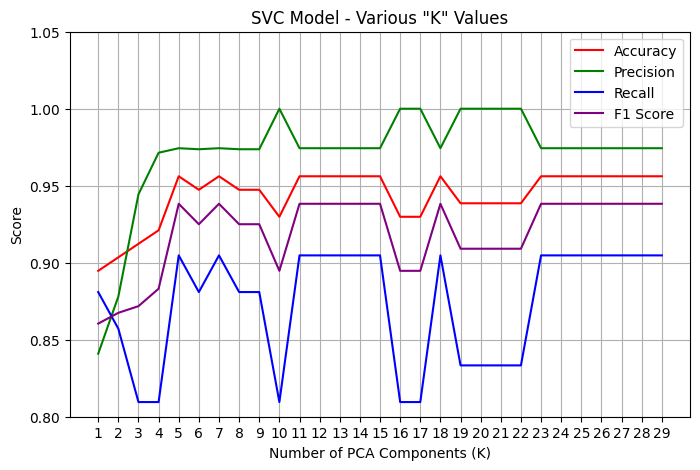

In [265]:
plt.figure(figsize=(8, 5))

plt.plot(pca_results_df['PCA Components'], pca_results_df['Accuracy'],linestyle='-', color='red', label='Accuracy')

plt.plot(pca_results_df['PCA Components'], pca_results_df['Precision'],linestyle='-', color='green', label='Precision')

plt.plot(pca_results_df['PCA Components'], pca_results_df['Recall'], linestyle='-', color='blue', label='Recall')

plt.plot(pca_results_df['PCA Components'], pca_results_df['F1 Score'], linestyle='-', color='purple', label='F1 Score')

plt.xlabel('Number of PCA Components (K)')
plt.ylabel('Score')
plt.title('SVC Model - Various "K" Values')
plt.legend()
plt.grid(True)
plt.xticks(pca_results_df['PCA Components'])
plt.ylim(0.8, 1.05)
plt.show()

# **PCA: Dimensionality Reduction (SVR)**

In [266]:
# dimensionality reduction for 2D plotting
pca_svr = PCA(n_components=1)
X_train_pca_svr = pca_svr.fit_transform(X_train_2)

#print(f"Original # of features: {X_train_2.shape[1]}")
#print(f"After PCA: {X_train_pca_lin.shape[1]}")

In [267]:
svr_model_pca_lin = SVR(kernel ='linear', C=1E6)
y_lin = svr_model_pca_lin.fit(X_train_pca_svr, Y_train_2).predict(X_train_pca_svr);

svr_model_pca_rbf = SVR(kernel ='rbf', C=1E5, gamma = 0.5)
y_rbf = svr_model_pca_rbf.fit(X_train_pca_svr, Y_train_2).predict(X_train_pca_svr);

svr_model_pca_poly = SVR(kernel ='poly', C=1E6, gamma = 'scale', coef0 = 0.5, degree = 1)
y_poly = svr_model_pca_poly.fit(X_train_pca_svr, Y_train_2).predict(X_train_pca_svr);

# **Figure 2-1**

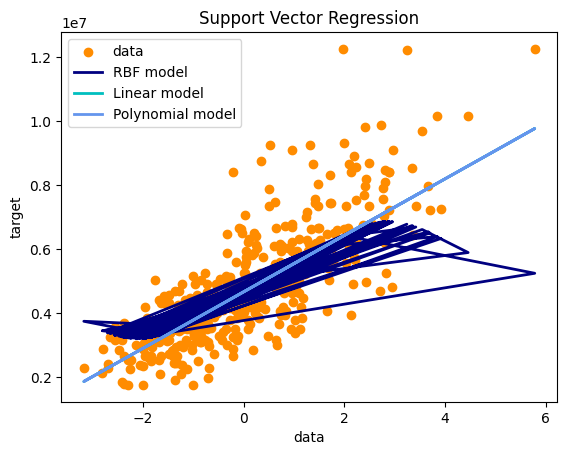

In [268]:
lw = 2
plt.scatter(X_train_pca_svr, Y_train_2, color='darkorange', label='data')
plt.plot(X_train_pca_svr, y_rbf, color='navy', lw=lw, label='RBF model')
plt.plot(X_train_pca_svr, y_lin, color='c', lw=lw, label='Linear model')
plt.plot(X_train_pca_svr, y_poly, color='cornflowerblue', lw=lw, label='Polynomial model')
plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

# **'N' Independent Training (SVR)**

In [269]:
# for loop to perform 'k' number of independent training
# pca + SVR
svr_rbf_results = []
svr_poly_results = []
svr_sig_results = []

for k in range(1,X_train_2.shape[1] + 1):
  pca_2 = PCA(n_components=k)
  X_train_pca_2 = pca_2.fit_transform(X_train_2)
  X_val_pca_2 = pca_2.transform(X_val_2)
                                                                                            # C = 1.0 by default
  svr_rbf_pca = SVR(C = 1E6, kernel = 'rbf', gamma = 0.5)                                   # kernel = 'rbf' by default
  svr_poly_pca = SVR(C = 1E6, kernel = 'poly', gamma = 'scale', coef0 = 0.5, degree = 1)    # degree = 3 by default, ignored by other kernels
  svr_sig_pca = SVR(C = 1E5, kernel = 'sigmoid', gamma = 'scale', coef0 = 0)                # gamma = 'scale' by default
                                                                                            # coef0 = 0 by default, not significant in rbf
  svr_rbf_pca.fit(X_train_pca_2, Y_train_2)
  predict_rbf_pca = svr_rbf_pca.predict(X_val_pca_2)
  r2_rbf = metrics.r2_score(Y_val_2, predict_rbf_pca)
  mse_rbf = metrics.mean_squared_error(Y_val_2, predict_rbf_pca)

  svr_poly_pca.fit(X_train_pca_2, Y_train_2)
  predict_poly_pca = svr_poly_pca.predict(X_val_pca_2)
  r2_poly = metrics.r2_score(Y_val_2, predict_poly_pca)
  mse_poly = metrics.mean_squared_error(Y_val_2, predict_poly_pca)

  svr_sig_pca.fit(X_train_pca_2, Y_train_2)
  predict_sig_pca = svr_sig_pca.predict(X_val_pca_2)
  r2_sig = metrics.r2_score(Y_val_2, predict_sig_pca)
  mse_sig = metrics.mean_squared_error(Y_val_2, predict_sig_pca)

  svr_rbf_results.append({"PCA Components": k, "R2 Score": r2_rbf, "MSE": mse_rbf})
  svr_poly_results.append({"PCA Components": k, "R2 Score": r2_poly, "MSE": mse_poly})
  svr_sig_results.append({"PCA Components": k, "R2 Score": r2_sig, "MSE": mse_sig})

svr_rbf_df = pd.DataFrame(svr_rbf_results)
svr_poly_df = pd.DataFrame(svr_poly_results)
svr_sig_df = pd.DataFrame(svr_sig_results)

display(svr_rbf_df)

,PCA Components,R2 Score,MSE
0,1,0.597856,1.688683e+12
1,2,0.593578,1.706644e+12
2,3,0.605862,1.655061e+12
3,4,0.577999,1.772065e+12
4,5,0.543639,1.916350e+12
5,6,0.555754,1.865474e+12
6,7,0.578020,1.771975e+12
7,8,0.503184,2.086228e+12
8,9,0.485045,2.162395e+12
9,10,0.475481,2.202557e+12


In [270]:
display(svr_poly_df)

,PCA Components,R2 Score,MSE
0,1,0.561401,1.841762e+12
1,2,0.562190,1.838451e+12
2,3,0.565779,1.823377e+12
3,4,0.566455,1.820540e+12
4,5,0.559937,1.847911e+12
5,6,0.563010,1.835008e+12
6,7,0.570278,1.804486e+12
7,8,0.555656,1.865887e+12
8,9,0.560462,1.845704e+12
9,10,0.565929,1.822750e+12


In [271]:
display(svr_sig_df)

,PCA Components,R2 Score,MSE
0,1,-0.454819,6.109070e+12
1,2,0.396889,2.532580e+12
2,3,0.468762,2.230774e+12
3,4,0.473789,2.209662e+12
4,5,0.468366,2.232437e+12
5,6,0.494378,2.123207e+12
6,7,0.520841,2.012081e+12
7,8,0.507070,2.069908e+12
8,9,0.510138,2.057026e+12
9,10,0.511980,2.049292e+12


# **Figure 2-2**

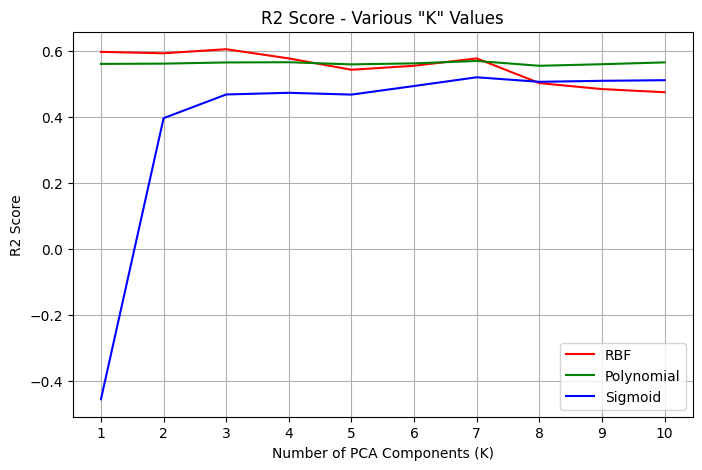

In [272]:
plt.figure(figsize=(8, 5))

plt.plot(svr_rbf_df['PCA Components'], svr_rbf_df['R2 Score'], linestyle='-', color='red', label='RBF')
plt.plot(svr_poly_df['PCA Components'], svr_poly_df['R2 Score'], linestyle='-', color='green', label='Polynomial')
plt.plot(svr_sig_df['PCA Components'], svr_sig_df['R2 Score'], linestyle='-', color='blue', label='Sigmoid')

plt.xlabel('Number of PCA Components (K)')
plt.ylabel('R2 Score')
plt.title('R2 Score - Various "K" Values')
plt.legend()
plt.grid(True)
plt.xticks(svr_rbf_df['PCA Components'])
plt.show()

# **Figure 2-3**

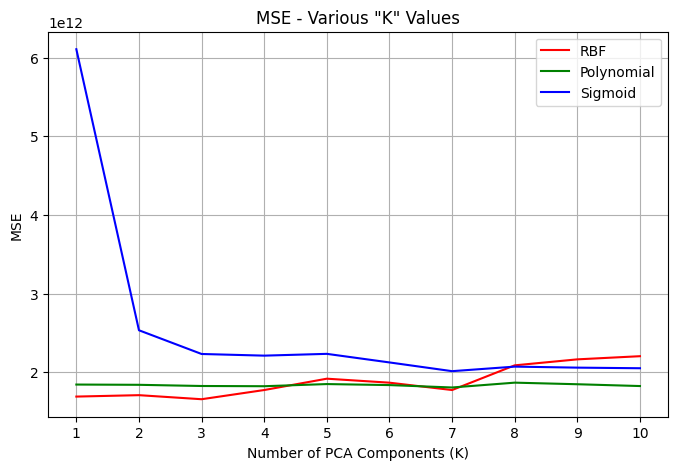

In [273]:
plt.figure(figsize=(8, 5))

plt.plot(svr_rbf_df['PCA Components'], svr_rbf_df['MSE'], linestyle='-', color='red', label='RBF')
plt.plot(svr_poly_df['PCA Components'], svr_poly_df['MSE'], linestyle='-', color='green', label='Polynomial')
plt.plot(svr_sig_df['PCA Components'], svr_sig_df['MSE'], linestyle='-', color='blue', label='Sigmoid')

plt.xlabel('Number of PCA Components (K)')
plt.ylabel('MSE')
plt.title('MSE - Various "K" Values')
plt.legend()
plt.grid(True)
plt.xticks(svr_rbf_df['PCA Components'])
plt.show()